In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.__version__

'2.1.0'

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pathlib, os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [34]:
import pandas as pd

In [5]:

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_1/cp.ckpt'

In [6]:
train_dir = pathlib.Path('inv/train_small')
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*') if item.name != "submission.csv"])
len(CLASS_NAMES)

137

In [7]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [8]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(137)
])

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
model.load_weights(latest)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

In [11]:
data_dir = pathlib.Path('inv/test_small')

image_count = len(list(data_dir.glob('*.jpeg')))

print(f'The test image count is {image_count}')

The test image count is 1434


In [12]:
test_ds = tf.data.Dataset.list_files(str(data_dir/'*'))

for f in test_ds.take(5):
  print(f.numpy())


b'inv/test_small/QFKAETC.jpeg'
b'inv/test_small/A3HT293.jpeg'
b'inv/test_small/1QVJEKD.jpeg'
b'inv/test_small/MZXAWLC.jpeg'
b'inv/test_small/6QGRK38.jpeg'


In [49]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  
  return tf.reshape(parts[-1] == CLASS_NAMES, [-1, 137])

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
  img = tf.reshape(img, [-1, 224,224,3])  
  return img

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [50]:
test_complete = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [51]:
for image, label in test_complete.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (1, 224, 224, 3)
Label:  [[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False]]


In [52]:
for image, label in test_complete.take(4):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (1, 224, 224, 3)
Label:  (1, 137)
Image shape:  (1, 224, 224, 3)
Label:  (1, 137)
Image shape:  (1, 224, 224, 3)
Label:  (1, 137)
Image shape:  (1, 224, 224, 3)
Label:  (1, 137)


In [53]:
evaluation = model.evaluate(test_complete, verbose=2)

1434/1434 - 44s - loss: 0.0162 - accuracy: 0.9974


In [105]:
prediction = model.predict(test_complete, verbose=2)

1434/1434 - 44s


In [111]:
prediction[4]

In [107]:
fourth_el = np.argmax(prediction[4])

In [108]:
str_link = CLASS_NAMES[fourth_el]

In [109]:
str_link, fourth_el

('Polychaete_worms', 74)

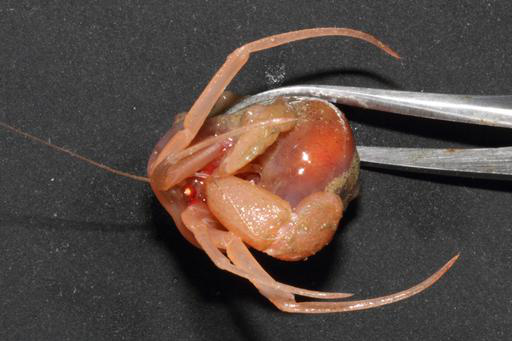

In [110]:
lim = list(data_dir.glob('*'))

image_path = lim[fourth_el]

display.display(Image.open(str(image_path)))

In [112]:
list_prediction = list(prediction)

In [113]:
list_prediction[4]

array([-16.769648 , -12.74738  , -14.463739 ,  -4.3236732,  -8.724507 ,
        -4.2361536, -10.800307 , -15.108839 , -12.219255 , -18.901356 ,
       -11.1063   , -16.713753 , -21.463009 , -12.8227215, -16.952477 ,
       -14.673555 , -16.504946 , -18.548346 ,  -8.590355 , -15.227181 ,
       -13.11205  , -14.404398 ,  -9.2314415, -15.262233 , -13.235226 ,
       -14.3963785, -10.0317335, -17.00912  , -23.04743  , -16.529003 ,
       -11.779407 , -15.856118 , -14.0830145, -14.533784 ,  -9.442093 ,
       -14.966124 , -16.928646 , -13.911424 , -24.363255 , -12.915721 ,
       -11.202628 , -21.115818 , -22.199368 , -12.686372 , -16.667414 ,
        -9.839881 , -17.52539  , -16.246267 , -14.392617 , -13.1281595,
       -13.048477 ,  -7.4685874,  -9.619185 , -21.614931 ,  -6.09775  ,
       -18.265392 , -10.69995  , -22.644447 ,  -8.273893 , -16.354584 ,
       -12.612905 , -12.493538 ,  -7.431845 ,  -7.9020567, -13.047913 ,
       -13.731773 , -11.057234 , -21.519764 , -12.72023  , -13.2